## Preparations

### Loading data

In [789]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import time
import matplotlib.pyplot as plt


In [790]:
df = pd.read_csv('datasets/autos.csv')

In [791]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [792]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [793]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [794]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Results**
1. Change column names from camel case
2. DateCrawled, last_seen - transform into data
3. VehicleType - explore what is inside - there are a lot of missing records 
4. Gearbox, Model, FuelType, NotRepaired - the same
5. RegistrationYear - calculate vehicle age?
6. Brand - transform using OHE?

### Transforming data

#### Renaming columns

In [795]:
column_name = []
for y in df.columns:
    column_name .append(y)
column_name_new=[]
for name in column_name:
    count = 0
    text = ''
    for symbol in name:
        if count == 0:
            text += symbol.lower()
            count = 1            
        elif symbol.isupper():
            text += "_" + symbol.lower()
        else:
            text += symbol
    column_name_new.append(text)
column_name = column_name_new
del column_name_new
column_name

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'not_repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

In [796]:
df.columns = column_name
df

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


#### Exploring vehicle_type

In [797]:
df['vehicle_type'].isnull().sum()

37490

In [798]:
df.groupby(by='vehicle_type')['date_crawled'].count()

vehicle_type
bus            28775
convertible    20203
coupe          16163
other           3288
sedan          91457
small          79831
suv            11996
wagon          65166
Name: date_crawled, dtype: int64

In [799]:
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

We have category called 'other'. We can use it to fill missing values. But there is a lot of missing values - this could mean that maybe there is some problem with initital data and missing values could for example mean dedan - the most popular vehicle type. So for now I decided to create new category - 'unknown'

#### Exploring gearbox

In [800]:
df['gearbox'].isnull().sum()

19833

In [801]:
df.groupby(by='gearbox')['date_crawled'].count()

gearbox
auto       66285
manual    268251
Name: date_crawled, dtype: int64

In [802]:
df['gearbox'] = df['gearbox'].fillna('manual')

In most cases we have manual gearbox. Having an automatic gearbox - is factor that could lead to a higher price, so it's unlikely that people would not put it to increase price.

So for missing values we can assume that people didn't mention it's manual since it's a "default" option

#### Exploring models

In [803]:
df['model'].isnull().sum()

19705

In [804]:
df.groupby(by='model')['model'].count().sort_values(ascending=False)

model
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

In [805]:
df['model'] = df['model'].fillna('unknown')

There are a lot of models, so there is no easy reasoning how can we fill missing values. We can use 'other' category, but for now we can just use 'unknown'

#### Exploring fuel_type

In [806]:
df['fuel_type'].isnull().sum()

32895

In [807]:
df.groupby(by='fuel_type')['model'].count().sort_values(ascending=False)

fuel_type
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: model, dtype: int64

In [808]:
df['fuel_type'] = df['fuel_type'].fillna('petrol')

Petrol seemed as a default choice, so most likely missing values we not filled because of it

#### Exploring not_repaired

In [809]:
df['not_repaired'].isnull().sum()

71154

In [810]:
df.groupby(by='not_repaired')['model'].count().sort_values(ascending=False)

not_repaired
no     247161
yes     36054
Name: model, dtype: int64

In [811]:
df['not_repaired'] = df['not_repaired'].fillna('no')

There is an overwhelming amount of cars that were not repaired. We can't assume that 66% of people who had their car repaired hid that fact, so it's more likely that people didn't put info, since not_repaired is a default choice

In [812]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Transforming data into necessary formats

1. Format dates into proper format
2. Changed format from object
3. Check if certain groups can be put into 1 to make it easier for the model

In [813]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])
df['last_seen'] = pd.to_datetime(df['last_seen'])
df['date_created'] = pd.to_datetime(df['date_created'])

In [814]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [815]:
df.groupby(by='vehicle_type')['date_crawled'].count()

vehicle_type
bus            28775
convertible    20203
coupe          16163
other           3288
sedan          91457
small          79831
suv            11996
unknown        37490
wagon          65166
Name: date_crawled, dtype: int64

There is not a lot of categories, we can leave them as is

In [816]:
df.groupby(by='gearbox')['date_crawled'].count()

gearbox
auto       66285
manual    288084
Name: date_crawled, dtype: int64

In [817]:
df.loc[df['gearbox'] == 'auto', 'gearbox'] = 1
df.loc[df['gearbox'] == 'manual', 'gearbox'] = 0

In [818]:
df['gearbox'] = df['gearbox'].astype(int)

In [819]:
df.groupby(by='fuel_type')['model'].count().sort_values(ascending=False)

fuel_type
petrol      249247
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: model, dtype: int64

In [820]:
df.loc[df['fuel_type'] == 'electric', 'fuel_type'] = 'other'
df.loc[df['fuel_type'] == 'hybrid', 'fuel_type'] = 'other'
df.loc[df['fuel_type'] == 'cng', 'fuel_type'] = 'other'
df.loc[df['fuel_type'] == 'lpg', 'fuel_type'] = 'other'

In [821]:
df.loc[df['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'
df.loc[df['fuel_type'] == 'petrol', 'fuel_type'] = 0
df.loc[df['fuel_type'] == 'other', 'fuel_type'] = 1

In [822]:
df['fuel_type'] = df['fuel_type'].astype(int)

lpg - could be separeated into different category, but having just 1 dummy variable is easier

In [823]:
df.groupby(by='not_repaired')['model'].count().sort_values(ascending=False)

not_repaired
no     318315
yes     36054
Name: model, dtype: int64

In [824]:
df.loc[df['not_repaired'] == 'no', 'not_repaired'] = 0
df.loc[df['not_repaired'] == 'yes', 'not_repaired'] = 1

In [825]:
df['not_repaired'] = df['not_repaired'].astype(int)

In [826]:
df.groupby(by='brand')['model'].count().sort_values(ascending=False)

brand
volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: model, dtype: int64

In [827]:
df.groupby(by='model')['model'].count().sort_values(ascending=False)

model
golf                  29232
other                 24421
3er                   19761
unknown               19705
polo                  13066
                      ...  
i3                        8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 251, dtype: int64

In [828]:
for model in df['model'].unique():
    x = df.loc[df['model'] == model]['brand'].unique().size
    if x > 1:
        print(model, df.loc[df['model'] == model]['brand'].unique())

unknown ['audi' 'sonstige_autos' 'fiat' 'volkswagen' 'renault' 'bmw' 'mitsubishi'
 'peugeot' 'alfa_romeo' 'volvo' 'toyota' 'chevrolet' 'trabant' 'saab'
 'opel' 'mercedes_benz' 'smart' 'nissan' 'skoda' 'ford' 'kia' 'suzuki'
 'hyundai' 'seat' 'mazda' 'citroen' 'chrysler' 'porsche' 'land_rover'
 'daewoo' 'lancia' 'honda' 'rover' 'mini' 'dacia' 'jaguar' 'daihatsu'
 'lada' 'subaru' 'jeep']
grand ['jeep' 'suzuki' 'chrysler']
other ['volkswagen' 'mercedes_benz' 'hyundai' 'seat' 'honda' 'mitsubishi' 'opel'
 'fiat' 'suzuki' 'lancia' 'mazda' 'nissan' 'toyota' 'chevrolet' 'renault'
 'peugeot' 'kia' 'citroen' 'bmw' 'ford' 'chrysler' 'audi' 'jaguar' 'skoda'
 'porsche' 'rover' 'smart' 'saab' 'alfa_romeo' 'mini' 'volvo' 'trabant'
 'lada' 'daewoo' 'jeep' 'daihatsu' 'subaru' 'dacia' 'land_rover']
3_reihe ['mazda' 'peugeot']
5_reihe ['mazda' 'peugeot']
matiz ['chevrolet' 'daewoo']
1_reihe ['mazda' 'peugeot']
discovery ['land_rover' 'rover']
freelander ['land_rover' 'rover']
defender ['land_rover' 'rover

3 most problematic variables are model, brand and vehicle_type. They have a a lot of different categories.

But there is a lot of models that a dirrectly connected to 1 spesific brand: out of 251 models only 10 can be attributed to multiple brands (2 of them are 'unknown' and 'other', so it's actually 8). Basically we can connect them to simplify data for the model. 

We can check the same with vehicle type

In [829]:
for model in df['model'].unique():
    x = df.loc[df['model'] == model]['vehicle_type'].unique().size
    if x > 1:
        print(model, df.loc[df['model'] == model]['vehicle_type'].unique())

golf ['unknown' 'small' 'sedan' 'bus' 'other' 'wagon' 'convertible' 'coupe'
 'suv']
unknown ['coupe' 'suv' 'small' 'sedan' 'wagon' 'unknown' 'other' 'bus'
 'convertible']
grand ['suv' 'bus' 'unknown' 'convertible' 'small']
fabia ['small' 'wagon' 'unknown' 'sedan' 'other' 'bus' 'convertible' 'suv']
3er ['sedan' 'coupe' 'convertible' 'unknown' 'wagon' 'small' 'other' 'suv'
 'bus']
2_reihe ['convertible' 'small' 'unknown' 'wagon' 'coupe' 'sedan' 'other' 'bus'
 'suv']
other ['sedan' 'other' 'bus' 'unknown' 'suv' 'coupe' 'small' 'wagon'
 'convertible']
c_max ['bus' 'unknown' 'sedan' 'wagon' 'other' 'suv' 'small']
3_reihe ['sedan' 'convertible' 'small' 'unknown' 'wagon' 'coupe' 'suv' 'bus'
 'other']
passat ['wagon' 'sedan' 'coupe' 'unknown' 'suv' 'bus' 'small' 'other'
 'convertible']
navara ['suv' 'unknown' 'other']
ka ['small' 'unknown' 'convertible' 'sedan' 'coupe' 'other' 'wagon']
polo ['unknown' 'small' 'sedan' 'wagon' 'coupe' 'convertible' 'bus' 'other'
 'suv']
twingo ['small' 'unknown'

Here it seems it seems we can't assume vehicle type only by the car model.

At the same time we have an intresting situation with for exaple "serie_1". We have only 2 types of vehicle type - "unkown" and "wagon". Basically in such situation we can replace unkkown with wagon. This is done by code below.

In [830]:
for model in df['model'].unique():
    y = df.loc[df['model'] == model]['vehicle_type'].unique()
    x = y.size
    if x == 2:
        if 'unknown' in y:
            if y[0] == 'unknown':
                z = y[0]
            else:
                z = y[1]
            df.loc[df['model'] == model, 'vehicle_type'] = z

In [831]:
df['brand_model'] = df['brand'] + "_" + df['model']

In [832]:
df = df.drop(['brand', 'model'],axis=1)

In [833]:
df

,date_crawled,price,vehicle_type,registration_year,gearbox,power,kilometer,registration_month,fuel_type,not_repaired,date_created,number_of_pictures,postal_code,last_seen,brand_model
0,2016-03-24 11:52:17,480,unknown,1993,0,0,150000,0,0,0,2016-03-24,0,70435,2016-04-07 03:16:57,volkswagen_golf
1,2016-03-24 10:58:45,18300,coupe,2011,0,190,125000,5,0,1,2016-03-24,0,66954,2016-04-07 01:46:50,audi_unknown
2,2016-03-14 12:52:21,9800,suv,2004,1,163,125000,8,0,0,2016-03-14,0,90480,2016-04-05 12:47:46,jeep_grand
3,2016-03-17 16:54:04,1500,small,2001,0,75,150000,6,0,0,2016-03-17,0,91074,2016-03-17 17:40:17,volkswagen_golf
4,2016-03-31 17:25:20,3600,small,2008,0,69,90000,7,0,0,2016-03-31,0,60437,2016-04-06 10:17:21,skoda_fabia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,unknown,2005,0,0,150000,7,0,1,2016-03-21,0,2694,2016-03-21 10:42:49,mitsubishi_colt
354365,2016-03-14 17:48:27,2200,unknown,2005,0,0,20000,1,0,0,2016-03-14,0,39576,2016-04-06 00:46:52,sonstige_autos_unknown
354366,2016-03-05 19:56:21,1199,convertible,2000,1,101,125000,3,0,0,2016-03-05,0,26135,2016-03-11 18:17:12,smart_fortwo
354367,2016-03-19 18:57:12,9200,bus,1996,0,102,150000,3,0,0,2016-03-19,0,87439,2016-04-07 07:15:26,volkswagen_transporter


### Checking for outliers

#### Year of registration

In [834]:
df.describe()

,price,registration_year,gearbox,power,kilometer,registration_month,fuel_type,not_repaired,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,0.187051,110.094337,128211.172535,5.714645,0.018066,0.101741,0.0,50508.689087
std,4514.158514,90.227958,0.389953,189.850405,37905.341530,3.726421,0.133190,0.302308,0.0,25783.096248
min,0.000000,1000.000000,0.000000,0.000000,5000.000000,0.000000,0.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,0.000000,69.000000,125000.000000,3.000000,0.000000,0.000000,0.0,30165.000000
50%,2700.000000,2003.000000,0.000000,105.000000,150000.000000,6.000000,0.000000,0.000000,0.0,49413.000000
75%,6400.000000,2008.000000,0.000000,143.000000,150000.000000,9.000000,0.000000,0.000000,0.0,71083.000000
max,20000.000000,9999.000000,1.000000,20000.000000,150000.000000,12.000000,1.000000,1.000000,0.0,99998.000000


<AxesSubplot:title={'center':'Year of registration distriburion'}>

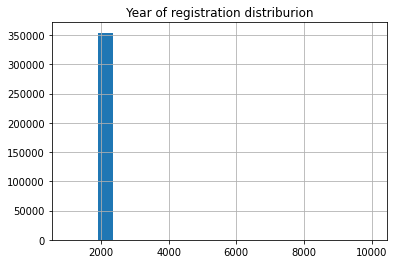

In [835]:
fig, axes = plt.subplots(facecolor='white')

plt.title('Year of registration distriburion')
df['registration_year'].hist(bins=20, ax=axes)

In [836]:
print(df.groupby(by='registration_year')['price'].count().head(20))
print(df.groupby(by='registration_year')['price'].count().tail(20))

registration_year
1000     37
1001      1
1039      1
1111      3
1200      1
1234      4
1253      1
1255      1
1300      2
1400      1
1500      5
1600      2
1602      1
1688      1
1800      5
1910    101
1915      1
1919      1
1920      1
1923      2
Name: price, dtype: int64
registration_year
5555     2
5600     1
5900     1
5911     2
6000     5
6500     1
7000     4
7100     1
7500     1
7800     1
8000     2
8200     1
8455     1
8500     1
8888     1
9000     3
9229     1
9450     1
9996     1
9999    26
Name: price, dtype: int64


In [837]:
df['registration_year'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [838]:
x = df['registration_year'].quantile(q=0.75)
y = df['registration_year'].quantile(q=0.25)
iqr = x - y
print(x+1.5*iqr)
print(y-1.5*iqr)

2021.5
1985.5


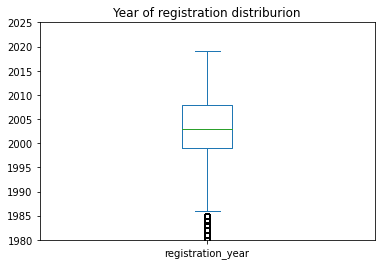

In [839]:
fig, axes = plt.subplots(facecolor='white')

plt.title('Year of registration distriburion')

ax = df['registration_year'].plot.box(ylim=(1980,2025))

In [840]:
df.query('registration_year>1985 and registration_year<2020')['price'].count()/df['price'].count()

0.9821965239623105

In [841]:
df.loc[df['registration_year']<1985, 'registration_year']=1985
df.loc[df['registration_year']>2020, 'registration_year']=2020

<AxesSubplot:title={'center':'Year of registration distriburion'}>

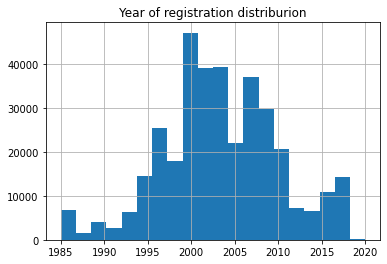

In [842]:
fig, axes = plt.subplots(facecolor='white')

plt.title('Year of registration distriburion')
df['registration_year'].hist(bins=20, ax=axes)

There are several problems with year of registration

1. DateCreated - is when we the advertisment was created, but we have cars where geristration year > 2016, so the ad for them happened earlier than the car was registered? The reason could be that it's not a real dataset - so for now I decided not to do anything with it.
2. We have many cars with unrealitic registration year (>2020 and <1900) It's clearly errors. Based on distribution (9)candle graph) 1985-2020 seems like a range for realistic years of registrarion. >98% of observations fall in it. So I correcteed errors by changing them in 1985 or 2020

#### Number_of_pictures

In [843]:
df.groupby(by='number_of_pictures')['price'].count()

number_of_pictures
0    354369
Name: price, dtype: int64

In [844]:
df = df.drop('number_of_pictures', axis=1)

The column "number_of_pictures" doesn't have any information

#### Power

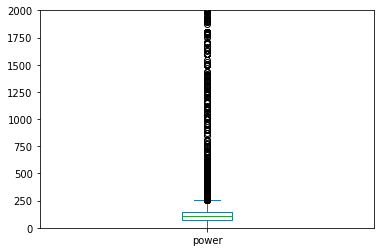

In [845]:
ax = df['power'].plot.box(ylim=(0,2000))

In [846]:
df.query('power > 2000')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,kilometer,registration_month,fuel_type,not_repaired,date_created,postal_code,last_seen,brand_model
7661,2016-04-02 19:25:25,1499,small,1999,0,7515,150000,4,0,0,2016-04-02,65830,2016-04-06 11:46:49,volkswagen_lupo
11039,2016-03-25 19:55:32,0,sedan,1998,0,10317,150000,8,0,0,2016-03-25,57520,2016-04-01 19:16:33,fiat_other
19092,2016-03-20 17:54:04,9750,wagon,2005,1,2729,150000,7,0,0,2016-03-20,21376,2016-03-23 02:48:53,bmw_5er
25232,2016-03-28 19:57:39,10900,bus,2009,0,10520,150000,6,0,0,2016-03-28,36272,2016-04-07 02:47:02,volkswagen_caddy
33952,2016-03-09 11:37:03,3740,small,2006,0,6920,90000,10,0,0,2016-03-09,94116,2016-03-17 05:16:32,toyota_aygo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346639,2016-03-25 12:55:36,1300,sedan,2000,0,12512,150000,9,0,0,2016-03-25,42105,2016-04-06 14:44:53,mitsubishi_carisma
346690,2016-03-24 11:50:41,7498,unknown,2017,1,2018,150000,9,0,0,2016-03-24,59425,2016-03-30 12:46:26,bmw_5er
348137,2016-03-16 21:48:39,850,sedan,1993,1,9012,150000,0,0,0,2016-03-16,14482,2016-04-03 09:17:43,volkswagen_golf
348237,2016-04-04 12:38:11,3000,coupe,2007,0,2007,150000,3,0,1,2016-04-04,72218,2016-04-04 12:38:11,opel_corsa


In [847]:
df.query('brand_model == "volkswagen_caddy"')['power'].median()

90.0

In [848]:
df.query('brand_model == "volkswagen_caddy"')['power'].unique()

array([   54,    75,    90,   102,     0,   105,    64,   109,    69,
         150,    70,   110,   140,    80,    86,   104,    60,    66,
          62,    68, 10520,   200,    55,    95,    65,    82,    63,
         130,   131,   108,   115,   107,   125,    67,   112,    59,
          77,   167,    84,   139,    50,    71,     1,   100,   101,
          47,   120,   106,    44,    79,   170,    98,   141,    40,
          87,   136,    73,    51], dtype=int64)

We have very big inconsistencies with enginge power. It ranges from 0 to 10520 for 1 model

The proposed solution:
* find median power for each model/brand
* compare this median power with the one in the record - if the difference is big (more than standard deviation) - we replace it with median, if it's within std - than we use the actual data

In [849]:
x = df['power'].std()
y = df['power'].mean()
df.query('power < @y+@x and power > @y-@x ')['price'].count()/df['price'].count()

0.989505289683917

In [850]:
power_car=pd.DataFrame(columns=['brand_model', 'median_power'])
for car in df['brand_model'].unique():
    x = df.query('brand_model == @car')['power'].median()
    power_car = power_car.append({'brand_model': car, 'median_power': x}, ignore_index=True)

In [851]:
df = df.merge(power_car, how='left', left_on='brand_model', right_on='brand_model')

In [852]:
df[df['median_power'].isna()]['price'].count()

0

In [853]:
x = df['power'].std()
df['final_power'] = np.where((df['power'] > df['median_power']+x) | (df['power'] < df['median_power']-x) | df['power'] == 0
                     , df['median_power'], df['power'] )

In [854]:
df = df.drop(['power', 'median_power'], axis = 1)

In [855]:
df['final_power'] =df['final_power'].astype(float)

#### Car age

In [856]:
df['car_age'] = df['date_created'].dt.year - df['registration_year']

In [857]:
df.query('car_age < 0')

,date_crawled,price,vehicle_type,registration_year,gearbox,kilometer,registration_month,fuel_type,not_repaired,date_created,postal_code,last_seen,brand_model,final_power,car_age
22,2016-03-23 14:52:51,2900,unknown,2018,0,150000,5,0,0,2016-03-23,49716,2016-03-31 01:16:33,opel_meriva,90.0,-2
26,2016-03-10 19:38:18,5555,unknown,2017,0,125000,4,0,0,2016-03-10,31139,2016-03-16 09:16:46,citroen_c4,125.0,-1
48,2016-03-25 14:40:12,7750,unknown,2017,0,100000,1,0,0,2016-03-25,48499,2016-03-31 21:47:44,volkswagen_golf,80.0,-1
51,2016-03-07 18:57:08,2000,unknown,2017,0,150000,11,0,1,2016-03-07,66115,2016-03-07 18:57:08,fiat_punto,90.0,-1
57,2016-03-10 20:53:19,2399,unknown,2018,0,125000,3,0,0,2016-03-10,33397,2016-03-25 10:17:37,seat_other,64.0,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,unknown,2017,0,150000,5,0,0,2016-03-11,32339,2016-03-12 05:45:02,ford_transit,86.0,-1
354140,2016-03-29 16:47:29,1000,unknown,2017,0,150000,9,0,0,2016-03-29,38315,2016-04-06 02:44:27,audi_a4,101.0,-1
354203,2016-03-17 00:56:26,2140,unknown,2018,0,150000,6,0,0,2016-03-17,44866,2016-03-29 15:45:04,ford_fiesta,80.0,-2
354253,2016-03-25 09:37:59,1250,unknown,2018,0,150000,0,0,0,2016-03-25,45527,2016-04-06 07:46:13,opel_corsa,60.0,-2


In [858]:
df = df.query('car_age > 0')

There is a strange situation with car_age less than 0. We can drop such records, since we can't check the sources of data. Altough it's more than 14k records

## ОНЕ/OrdinalEncoder

In [859]:
df_ohe = pd.concat([df, pd.get_dummies(df['vehicle_type'], drop_first=True)],axis=1, sort=False)

In [860]:
df_ohe

,date_crawled,price,vehicle_type,registration_year,gearbox,kilometer,registration_month,fuel_type,not_repaired,date_created,postal_code,last_seen,brand_model,final_power,car_age,convertible,coupe,other,sedan,small,suv,unknown,wagon
0,2016-03-24 11:52:17,480,unknown,1993,0,150000,0,0,0,2016-03-24,70435,2016-04-07 03:16:57,volkswagen_golf,95.0,23,0,0,0,0,0,0,1,0
1,2016-03-24 10:58:45,18300,coupe,2011,0,125000,5,0,1,2016-03-24,66954,2016-04-07 01:46:50,audi_unknown,190.0,5,0,1,0,0,0,0,0,0
2,2016-03-14 12:52:21,9800,suv,2004,1,125000,8,0,0,2016-03-14,90480,2016-04-05 12:47:46,jeep_grand,163.0,12,0,0,0,0,0,1,0,0
3,2016-03-17 16:54:04,1500,small,2001,0,150000,6,0,0,2016-03-17,91074,2016-03-17 17:40:17,volkswagen_golf,75.0,15,0,0,0,0,1,0,0,0
4,2016-03-31 17:25:20,3600,small,2008,0,90000,7,0,0,2016-03-31,60437,2016-04-06 10:17:21,skoda_fabia,69.0,8,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,unknown,2005,0,150000,7,0,1,2016-03-21,2694,2016-03-21 10:42:49,mitsubishi_colt,75.0,11,0,0,0,0,0,0,1,0
354365,2016-03-14 17:48:27,2200,unknown,2005,0,20000,1,0,0,2016-03-14,39576,2016-04-06 00:46:52,sonstige_autos_unknown,49.5,11,0,0,0,0,0,0,1,0
354366,2016-03-05 19:56:21,1199,convertible,2000,1,125000,3,0,0,2016-03-05,26135,2016-03-11 18:17:12,smart_fortwo,101.0,16,1,0,0,0,0,0,0,0
354367,2016-03-19 18:57:12,9200,bus,1996,0,150000,3,0,0,2016-03-19,87439,2016-04-07 07:15:26,volkswagen_transporter,102.0,20,0,0,0,0,0,0,0,0


In [861]:
df_ohe = pd.concat([df_ohe, pd.get_dummies(df['brand_model'], drop_first=True)],axis=1, sort=False)

In [862]:
df_ohe = df_ohe.drop(['brand_model', 'vehicle_type'], axis = 1)
df_ohe = df_ohe.fillna(0)

In [863]:
df_ohe = df_ohe.fillna(0)
df_ohe

,date_crawled,price,registration_year,gearbox,kilometer,registration_month,fuel_type,not_repaired,date_created,postal_code,last_seen,final_power,car_age,convertible,coupe,other,sedan,small,suv,unknown,wagon,alfa_romeo_147,alfa_romeo_156,alfa_romeo_159,alfa_romeo_other,alfa_romeo_spider,alfa_romeo_unknown,audi_100,audi_200,audi_80,audi_90,audi_a1,audi_a2,audi_a3,audi_a4,audi_a5,audi_a6,audi_a8,audi_other,audi_q3,audi_q5,audi_q7,audi_tt,audi_unknown,bmw_1er,bmw_3er,bmw_5er,bmw_6er,bmw_7er,bmw_i3,bmw_m_reihe,bmw_other,bmw_unknown,bmw_x_reihe,bmw_z_reihe,chevrolet_aveo,chevrolet_captiva,chevrolet_matiz,chevrolet_other,chevrolet_spark,chevrolet_unknown,chrysler_300c,chrysler_crossfire,chrysler_grand,chrysler_other,chrysler_ptcruiser,chrysler_unknown,chrysler_voyager,citroen_berlingo,citroen_c1,citroen_c2,citroen_c3,citroen_c4,citroen_c5,citroen_other,citroen_unknown,dacia_duster,dacia_lodgy,dacia_logan,dacia_other,dacia_sandero,dacia_unknown,daewoo_kalos,daewoo_lanos,daewoo_matiz,daewoo_nubira,daewoo_other,daewoo_unknown,daihatsu_charade,daihatsu_cuore,daihatsu_materia,daihatsu_move,daihatsu_other,daihatsu_sirion,daihatsu_terios,daihatsu_unknown,fiat_500,fiat_bravo,fiat_croma,fiat_doblo,fiat_ducato,fiat_other,fiat_panda,fiat_punto,fiat_seicento,fiat_stilo,fiat_unknown,ford_b_max,ford_c_max,ford_escort,ford_fiesta,ford_focus,ford_fusion,ford_galaxy,ford_ka,ford_kuga,ford_mondeo,ford_mustang,ford_other,ford_s_max,ford_transit,ford_unknown,honda_accord,honda_civic,honda_cr_reihe,honda_jazz,honda_other,honda_unknown,hyundai_getz,hyundai_i_reihe,hyundai_other,hyundai_santa,hyundai_tucson,hyundai_unknown,jaguar_other,jaguar_s_type,jaguar_unknown,jaguar_x_type,jeep_cherokee,jeep_grand,jeep_other,jeep_unknown,jeep_wrangler,kia_carnival,kia_ceed,kia_other,kia_picanto,kia_rio,kia_sorento,kia_sportage,kia_unknown,lada_kalina,lada_niva,lada_other,lada_samara,lada_unknown,lancia_delta,lancia_elefantino,lancia_kappa,lancia_lybra,lancia_musa,lancia_other,lancia_unknown,lancia_ypsilon,land_rover_defender,land_rover_discovery,land_rover_freelander,land_rover_other,land_rover_range_rover,land_rover_range_rover_evoque,land_rover_range_rover_sport,land_rover_serie_1,land_rover_serie_2,land_rover_serie_3,land_rover_unknown,mazda_1_reihe,mazda_3_reihe,mazda_5_reihe,mazda_6_reihe,mazda_cx_reihe,mazda_mx_reihe,mazda_other,mazda_rx_reihe,mazda_unknown,mercedes_benz_a_klasse,mercedes_benz_b_klasse,mercedes_benz_c_klasse,mercedes_benz_cl,mercedes_benz_clk,mercedes_benz_e_klasse,mercedes_benz_g_klasse,mercedes_benz_gl,mercedes_benz_glk,mercedes_benz_m_klasse,mercedes_benz_other,mercedes_benz_s_klasse,mercedes_benz_sl,mercedes_benz_slk,mercedes_benz_sprinter,mercedes_benz_unknown,mercedes_benz_v_klasse,mercedes_benz_viano,mercedes_benz_vito,mini_clubman,mini_cooper,mini_one,mini_other,mini_unknown,mitsubishi_carisma,mitsubishi_colt,mitsubishi_galant,mitsubishi_lancer,mitsubishi_other,mitsubishi_outlander,mitsubishi_pajero,mitsubishi_unknown,nissan_almera,nissan_juke,nissan_micra,nissan_navara,nissan_note,nissan_other,nissan_primera,nissan_qashqai,nissan_unknown,nissan_x_trail,opel_agila,opel_antara,opel_astra,opel_calibra,opel_combo,opel_corsa,opel_insignia,opel_kadett,opel_meriva,opel_omega,opel_other,opel_signum,opel_tigra,opel_unknown,opel_vectra,opel_vivaro,opel_zafira,peugeot_1_reihe,peugeot_2_reihe,peugeot_3_reihe,peugeot_4_reihe,peugeot_5_reihe,peugeot_other,peugeot_unknown,porsche_911,porsche_boxster,porsche_cayenne,porsche_other,porsche_unknown,renault_clio,renault_espace,renault_kangoo,renault_laguna,renault_megane,renault_modus,renault_other,renault_r19,renault_scenic,renault_twingo,renault_unknown,rover_defender,rover_discovery,rover_freelander,rover_other,rover_rangerover,rover_unknown,saab_900,saab_9000,saab_other,saab_unknown,seat_alhambra,seat_altea,seat_arosa,seat_cordoba,seat_exeo,seat_ibiza,seat_leon,seat_mii,seat_other,seat_toledo,seat_unknown,skoda_citigo,skoda_fabia,skoda_octavia,skoda_other,skoda_roomster,skoda_superb,skoda_unknown,skoda

In [864]:
encoder = OrdinalEncoder()
df_ord = df.copy(deep=True)
df_ord[["vehicle_type","brand_model"]] = encoder.fit_transform(df[["vehicle_type","brand_model"]])
df_ord

,date_crawled,price,vehicle_type,registration_year,gearbox,kilometer,registration_month,fuel_type,not_repaired,date_created,postal_code,last_seen,brand_model,final_power,car_age
0,2016-03-24 11:52:17,480,7.0,1993,0,150000,0,0,0,2016-03-24,70435,2016-04-07 03:16:57,311.0,95.0,23
1,2016-03-24 10:58:45,18300,2.0,2011,0,125000,5,0,1,2016-03-24,66954,2016-04-07 01:46:50,23.0,190.0,5
2,2016-03-14 12:52:21,9800,6.0,2004,1,125000,8,0,0,2016-03-14,90480,2016-04-05 12:47:46,119.0,163.0,12
3,2016-03-17 16:54:04,1500,5.0,2001,0,150000,6,0,0,2016-03-17,91074,2016-03-17 17:40:17,311.0,75.0,15
4,2016-03-31 17:25:20,3600,5.0,2008,0,90000,7,0,0,2016-03-31,60437,2016-04-06 10:17:21,268.0,69.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,7.0,2005,0,150000,7,0,1,2016-03-21,2694,2016-03-21 10:42:49,189.0,75.0,11
354365,2016-03-14 17:48:27,2200,7.0,2005,0,20000,1,0,0,2016-03-14,39576,2016-04-06 00:46:52,280.0,49.5,11
354366,2016-03-05 19:56:21,1199,1.0,2000,1,125000,3,0,0,2016-03-05,26135,2016-03-11 18:17:12,276.0,101.0,16
354367,2016-03-19 18:57:12,9200,0.0,1996,0,150000,3,0,0,2016-03-19,87439,2016-04-07 07:15:26,324.0,102.0,20


We can use both Ordinal encoding and OHE. But since I found that we can set categorical features in lightgbm - it's easier to do OrdinalEncoder.

## Conclusions for preparation stage

1.	Data was loaded and preliminary analysis showed 4 major problems:  missing values, wrong data formats, categorical variables and statistical outliers that signaled errors
2.	The missing values were all filled using most fitting method: vehicle_type, models – filled with unknown value, gearbox, fuel_type, not_repaired – with the most prevalent in df value
3.	Data formats were change for date variables, and categorical data was changed into dummy variables
4.	There were 3 variables that had a lot of categories – brand, model and vehicle_type. The first 2 had a lot in common – model in most cases was directly connected to 1 brand. So they were put together in 1 variable. 
5.	There were several variables that had significant statistical outliers, year of registration, number of pictures, power. All of them were explored and outliers were corrected. During this stage I found additional error – the year of car registration was bigger, than the year when ad for selling the car was placed. Such observations were dropped 
6.	Using OHE for model_brand and vehicle_type led to an increased number of columns. But later we need to use lightgdm – we don’t need to turn categorical data in these columns – we can use Ordinal Encoder and specify to the model that this columns are categorical


## Modeling

### Creating subsamples

In [865]:
features_train, features_test, target_train, target_test = train_test_split(
    df_ord.drop(['price', 'date_crawled', 'date_created', 'last_seen'], axis=1),
    df_ord['price'], random_state = 12345, test_size=0.2) 

In [866]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, random_state = 12345, test_size=0.2) 

### Models

In [867]:
lgb_train = lgb.Dataset(features_train, target_train, categorical_feature=['vehicle_type', 'brand_model'],
                       free_raw_data=False )
lgb_valid  = lgb.Dataset(features_valid, target_valid, reference=lgb_train,
                         categorical_feature=['vehicle_type', 'brand_model'],free_raw_data=False )

In [868]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 131,
    'learning_rate': 0.15,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    'tree_learner' : 'feature',
    'seed' : 12345
}

In [869]:
%%time
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_valid,
                early_stopping_rounds=5)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 880
[LightGBM] [Info] Number of data points in the train set: 211352, number of used features: 11
[LightGBM] [Info] Start training from score 4542.429137
[1]	valid_0's rmse: 4029.37
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 3598.62
[3]	valid_0's rmse: 3246.78
[4]	valid_0's rmse: 2957.71
[5]	valid_0's rmse: 2722.05
[6]	valid_0's rmse: 2533.19
[7]	valid_0's rmse: 2379.79
[8]	valid_0's rmse: 2260.45
[9]	valid_0's rmse: 2164.81
[10]	valid_0's rmse: 2086.73
[11]	valid_0's rmse: 2024.04
[12]	valid_0's rmse: 1974.08
[13]	valid_0's rmse: 1933.9
[14]	valid_0's rmse: 1899.99
[15]	valid_0's rmse: 1875.16
[16]	valid_0's rmse: 1853.37
[17]	valid_0's rmse: 1834.81
[18]	valid_0's rmse: 1819.68
[19]	valid_0's r

In [870]:
def rmse_check(features, target, model):
    predict = model.predict(features)
    rmse = mean_squared_error(target, predict) ** 0.5
    return rmse

In [871]:
print("RMSE train:", rmse_check(features_train, target_train, gbm))
print("RMSE valid:", rmse_check(features_valid, target_valid, gbm))
print("RMSE test:", rmse_check(features_test, target_test, gbm))

RMSE train: 1499.0976345122037
RMSE valid: 1710.0169694418144
RMSE test: 1700.406591432949


In [872]:
param_grid = {
    'num_leaves': [127,  400],
    'min_data_in_leaf': [30,  400],
    'learning_rate': [0.1, 0.2],
    'metric': ['rmse'],
    'seed' : [12345],
    'verbose': [3],
    'num_boost_round':[100],
    }

In [873]:
lgb_estimator = lgb.LGBMRegressor(boosting_type='gbdt' )

In [874]:
def rmse_check1(fact, predict):
    rmse = mean_squared_error(fact, predict) ** 0.5
    return rmse

In [875]:
score_rmse = make_scorer(rmse_check1, greater_is_better=False)

In [876]:
%%time
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, scoring=score_rmse, verbose=3)
lgb_model = gsearch.fit(X=features_train, y=target_train, )

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.896012
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.260994
[LightGBM] [Debug] init for col-wise cost 0.006206 seconds, init for row-wise cost 0.019964 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 823
[LightGBM] [

In [877]:
print(lgb_model.best_params_, lgb_model.best_score_)

{'learning_rate': 0.1, 'metric': 'rmse', 'min_data_in_leaf': 30, 'num_boost_round': 100, 'num_leaves': 400, 'seed': 12345, 'verbose': 3} -1713.74864370646


In [878]:
print("RMSE train:", rmse_check(features_train, target_train, lgb_model))
print("RMSE valid:", rmse_check(features_valid, target_valid, lgb_model))
print("RMSE test:", rmse_check(features_test, target_test, lgb_model))

RMSE train: 1438.2877035858253
RMSE valid: 1701.3577875130347
RMSE test: 1694.4354929022975


**Results**
1. Build a model using lightgbm library 
2. GridSearch was used in second model to find best parameters

### Comparing models

In [879]:
params1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 131,
    'learning_rate': 0.15,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    'tree_learner' : 'feature',
    'seed' : 12345
}

In [880]:
%%time
start = time.time()
gbm1 = lgb.train(params1,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_valid,
                early_stopping_rounds=5)
end = time.time()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 880
[LightGBM] [Info] Number of data points in the train set: 211352, number of used features: 11
[LightGBM] [Info] Start training from score 4542.429137
[1]	valid_0's rmse: 4029.37
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 3598.62
[3]	valid_0's rmse: 3246.78
[4]	valid_0's rmse: 2957.71
[5]	valid_0's rmse: 2722.05
[6]	valid_0's rmse: 2533.19
[7]	valid_0's rmse: 2379.79
[8]	valid_0's rmse: 2260.45
[9]	valid_0's rmse: 2164.81
[10]	valid_0's rmse: 2086.73
[11]	valid_0's rmse: 2024.04
[12]	valid_0's rmse: 1974.08
[13]	valid_0's rmse: 1933.9
[14]	valid_0's rmse: 1899.99
[15]	valid_0's rmse: 1875.16
[16]	valid_0's rmse: 1853.37
[17]	valid_0's rmse: 1834.81
[18]	valid_0's rmse: 1819.68
[19]	valid_0's r

In [881]:
results = pd.DataFrame(columns=['rmse', 'exc_time'])

In [882]:
results = results.append({'rmse': rmse_check(features_test, target_test, gbm1),
                'exc_time': end-start}, ignore_index=True )

In [883]:
params2 = {
    'num_leaves': 400,
    'min_data_in_leaf': 30,
    'learning_rate': 0.1,
    'metric': 'rmse',
    'seed' : 12345,
    'verbose': 3,
    'num_boost_round':100,
    }

In [884]:
%%time
start = time.time()
gbm2 = lgb.train(params2,
                lgb_train,
                valid_sets=lgb_valid,
                early_stopping_rounds=5)
end = time.time()

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.896020
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.261870
[LightGBM] [Debug] init for col-wise cost 0.007127 seconds, init for row-wise cost 0.024093 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 880
[LightGBM] [Info] Number of data points in the train set: 211352, number of used features: 11
[LightGBM] [Info] Start training from score 4542.429137
[LightGBM] [Debug] Trained a tree with leaves = 400 and depth = 14
[1]	valid_0's rmse: 4190.81
Training until validation scores don't improve for 5 rounds
[LightGBM] [Debug] Trained a tree with leaves = 400 and depth = 15
[2]	valid_0's rmse: 3868.35
[LightGBM] [Debug] Trained a tree w

In [885]:
results = results.append({'rmse': rmse_check(features_test, target_test, gbm2),
                'exc_time': end-start}, ignore_index=True )

In [886]:
results

,rmse,exc_time
0,1700.406591,2.987235
1,1676.979532,4.974277


## Conclusions

1. All the needed preparations were completed
2. 2 models were used: regressions and decision tree. The first one is calculated faster 3 vs 5 second. But the resulting rmse is 1.5% worse. 2 second difference is not that significant, although depending on the machine the code is running the difference in time could be more pronounced. In that case the increase in the quality of model may be not worth it.